In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn

seaborn.set()
seaborn.set_style("ticks")
seaborn.set_context("poster")
from matplotlib import pyplot

In [81]:
def print_compress(title, data, stds, marker_styles, curve_colors, curve_styles,
                   curve_labels, yticks, leg_title, rand_base, leg_loc, leg_flag, name):
    fig, ax = plt.subplots(figsize=(4, 3))
    plt.title(title , fontsize=25)
    plt.xlabel(r'Model Size Factor', fontsize=25)
    plt.ylabel(r'Compressibity (%)', fontsize=25)
    plt.xlim((0.245, 4.07))
    plt.ylim((-1, np.max(yticks)))
    plt.grid(True, which='both')
    plt.xscale('log')
    plt.xticks(size_factors, size_labels)
    plt.yticks(yticks)

    for curve_idx in range(np.shape(data)[0]):
        non_0_idx = (data[curve_idx,:] != 0)
        plt.errorbar(size_factors[non_0_idx], data[curve_idx,non_0_idx], yerr=stds[curve_idx,non_0_idx],
                 marker=marker_styles[curve_idx], markersize=7, color=curve_colors[curve_idx],
                 linestyle=curve_styles[curve_idx], linewidth=3)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    if leg_flag:
        leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=12, title=leg_title)
        leg.get_title().set_fontsize('12')
    plt.rc('xtick',labelsize=8)

    plt.show()
    fig.savefig(name+".pdf",format='pdf', bbox_inches='tight',dpi=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


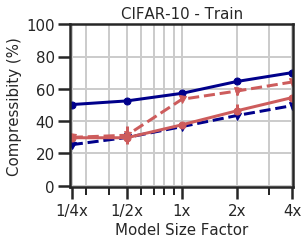

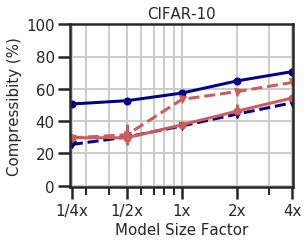

In [82]:
sys.path.append('../')
import experiments

curves = 4
curve_labels = ['AlexNet', 'AlexNet-Random', 'ResNet56', 'ResNet56-Random']
curve_colors = ['darkblue', 'darkblue', 'indianred', 'indianred']
curve_styles = ['-', '--', '-', '--']
marker_styles = ['o', 'v', 'o', 'v']

yticks = [0, 20, 40, 60, 80, 100]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
sizes = 5
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds = 2

results = np.zeros((seeds,curves, sizes))
results_test = np.zeros((seeds,curves, sizes))
# both are indexed [size_factor][nn_type][mean/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages between samplings and not nets

for seed in range(seeds):

    for ID in range(62, 92):

        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 1  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 0  # all regularizers
        else:
            continue

        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)

    for ID in range(217, 231):

        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 3  # random labels
        elif opt.hyper.lr_bs_factor == 1:
            curve_idx = 2  # all regularizers
        else:
            continue

        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)

results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.0, 0.42)

print_compress(r'CIFAR-10 - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 10,leg_loc, False,
                 "comp_cifar_train")

print_compress(r'CIFAR-10', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 10,leg_loc, False,
                 "comp_cifar_test")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


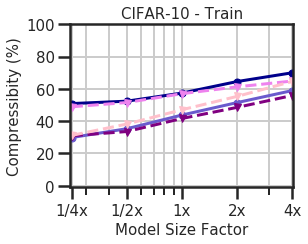

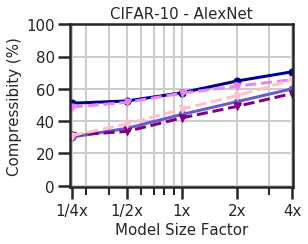

In [83]:

sys.path.append('../')
import experiments

curves = 5
curve_labels = ['None', 'All', 'Data Aug.', 'Dropout', 'W. Decay']
curve_colors = ['slateblue', 'darkblue', 'purple', 'violet', 'pink']
curve_styles = ['-', '-', '--', '--', '--']
marker_styles = ['o', 'o', 'v', 'v', 'v']
yticks = [0, 20, 40, 60, 80, 100]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
sizes = 5
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

seeds = 3
results = np.zeros((seeds, curves, sizes))
results_test = np.zeros((seeds, curves, sizes))
# both are indexed [size_factor][nn_type][mean/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages between samplings and not nets

for seed in range(seeds):
    for ID in range(62, 92):

        opt = experiments.opt[ID]

        curve_idx = 0  # unregularized
        if opt.dataset.random_labels:
            continue  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 1  # all regularizers
        elif opt.hyper.augmentation:
            curve_idx = 2
        elif opt.hyper.drop_train < 1:
            curve_idx = 3
        elif opt.hyper.weight_decay:
            curve_idx = 4
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)

results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.0, 0.42)


print_compress(r'CIFAR-10 - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 10,leg_loc, False,
                 "comp_cifar_regularizers_train")

print_compress(r'CIFAR-10 - AlexNet', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 10,leg_loc, False,
                 "comp_cifar_regularizers_test")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


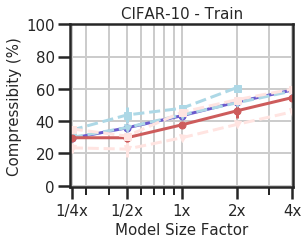

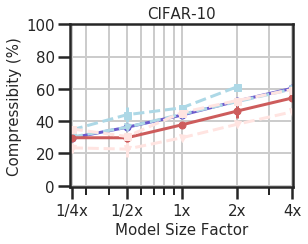

In [84]:
#Batch -CIFAR
sys.path.append('../')
import experiments

curves = 6
curve_labels = ['AlexNet-k=1', 'AlexNet-k=0.25', 'AlexNet-k=4', 'ResNet-k=1', 'ResNet-k=0.25', 'ResNet-k=4']
curve_colors = ['slateblue', 'lightblue', 'lightblue', 'indianred', 'mistyrose', 'mistyrose']
curve_styles = ['-', '--', '--', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'o', 'v', 's']
lr_factor = [1, 0.25, 4]
yticks = [0, 20, 40, 60, 80, 100]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
sizes = 5
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

seeds = 2
results = np.zeros((seeds, curves, sizes))
results_test = np.zeros((seeds, curves, sizes))
# both are indexed [size_factor][nn_type][mean/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages between samplings and not nets

for seed in range(seeds):
    for ID in list(range(62, 92)) + list(range(157,217)) :

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        if not (opt.hyper.augmentation or opt.hyper.drop_train < 1 or opt.hyper.weight_decay):
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0]
        else:
            continue
            
        if ID == 166: #Not possible to calculate
            continue
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
    for ID in list(range(217,232)) + list(range(234,239)):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        else:
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0] + 3
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)

results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.0, 0.42)


print_compress(r'CIFAR-10 - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 10,leg_loc, False,
                 "comp_cifar_batch_train")

print_compress(r'CIFAR-10', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 10,leg_loc, False,
                 "comp_cifar_batch_test")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


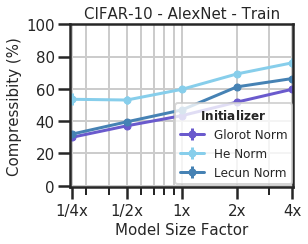

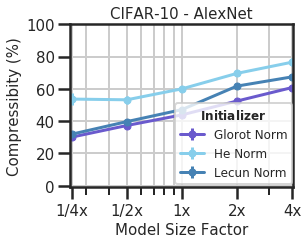

In [85]:
#Init -CIFAR
sys.path.append('../')
import experiments

curves = 3
curve_labels = ['Glorot Norm', 'He Norm', 'Lecun Norm']
curve_colors = ['slateblue', 'skyblue', 'steelblue']
curve_styles = ['-',  '-',  '-']
marker_styles = ['o', 'o','o']
yticks = [0, 20, 40, 60, 80, 100]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
sizes = 5
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

seeds = 2
results = np.zeros((seeds, curves, sizes))
results_test = np.zeros((seeds, curves, sizes))
# both are indexed [size_factor][nn_type][mean/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages between samplings and not nets

for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]
        curve_idx = opt.init_type // 2
        if opt.init_type in [1, 3, 5]:
            continue
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.47, 0.02)


print_compress(r'CIFAR-10 - AlexNet - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 10,leg_loc, True,
                 "comp_cifar_initializers_train")

print_compress(r'CIFAR-10 - AlexNet', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 10,leg_loc, True,
                 "comp_cifar_initializers_test")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


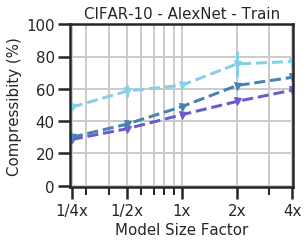

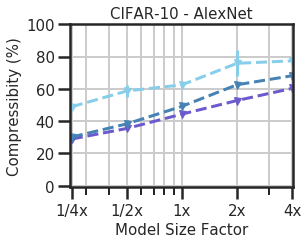

In [86]:
#Init -CIFAR
sys.path.append('../')
import experiments

curves = 3
curve_labels = ['Glorot Unif.', 'He Unif.', 'Lecun Unif.']
curve_colors = ['slateblue', 'skyblue',  'steelblue']
curve_styles = ['--', '--', '--']
marker_styles = ['v', 'v', 'v']
yticks = [0, 20, 40, 60, 80, 100]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
sizes = 5
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

seeds = 2
results = np.zeros((seeds, curves, sizes))
results_test = np.zeros((seeds, curves, sizes))
# both are indexed [size_factor][nn_type][mean/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages between samplings and not nets

for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [0, 2, 4]:
            continue 
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.0, 0.42)


print_compress(r'CIFAR-10 - AlexNet - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 10,leg_loc, False,
                 "comp_cifar_initializers2_train")

print_compress(r'CIFAR-10 - AlexNet', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 10,leg_loc, False,
                 "comp_cifar_initializers2_test")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


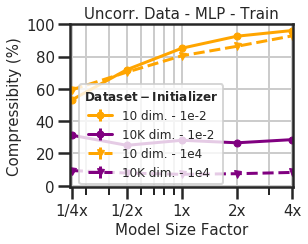

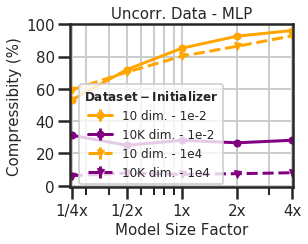

In [87]:
#MLPs

sys.path.append('../')
import experiments


curves = 5
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]

curves = 4
curve_labels = ['10 dim. - 1e-2', '10K dim. - 1e-2', '10 dim. - 1e4', '10K dim. - 1e4']
curve_colors = ['orange', 'purple', 'orange', 'purple']
curve_styles = ['-', '-', '--',  '--']
marker_styles = ['o', 'o', 'v',  'v']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 1



results = -np.zeros((seeds, curves, sizes))
results_test = -np.zeros((seeds, curves, sizes))

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for ID in range(243+0, 243+100):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]
        
        if opt.dataset.dataset_name == "rand10000":
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 1
        else:
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 0

        if not opt.hyper.learning_rate == select_lr[curve_idx]:
            continue
            
        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]      

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
    for ID in range(343, 542):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10000":
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 3
        else:
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 2

        if not opt.hyper.init_factor == 1e6:
            continue
            
        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]      

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.04, 0.02)


print_compress(r'Uncorr. Data - MLP - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 10,leg_loc, True,
                 "comp_synthetic_train")

print_compress(r'Uncorr. Data - MLP', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 10,leg_loc, True,
                 "comp_synthetic_test")      


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


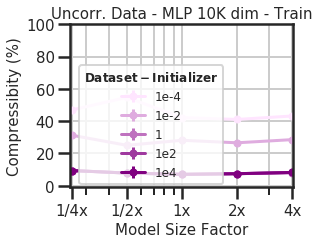

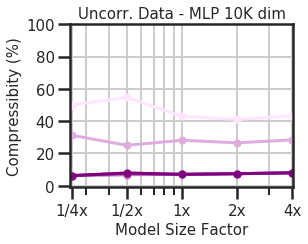

In [88]:
#MLPs

sys.path.append('../')
import experiments


curves = 5
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]

curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("purple", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 1



results = -np.zeros((seeds, curves, sizes))
results_test = -np.zeros((seeds, curves, sizes))

for seed in range(seeds):
    for ID in range(343, 542):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10000":
            if opt.dnn.name == 'MLP1_linear':
                continue
        else:
            continue

        if not opt.hyper.init_factor in inits_fact:
            continue

        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   
        curve_idx = np.where(np.array(opt.hyper.init_factor) == (inits_fact))[0][0]       

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.04, 0.02)


print_compress(r'Uncorr. Data - MLP 10K dim - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 10,leg_loc, True,
                 "comp_synthetic_initializer_train")

print_compress(r'Uncorr. Data - MLP 10K dim', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 10,leg_loc, False,
                 "comp_synthetic_initializer_test")      


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


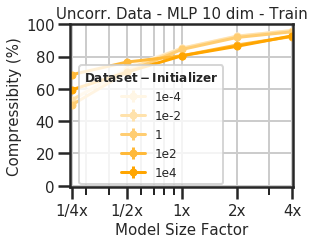

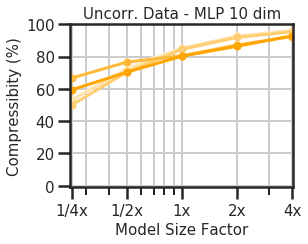

In [89]:
#MLPs

sys.path.append('../')
import experiments


curves = 5
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]

curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("orange", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 1



results = -np.zeros((seeds, curves, sizes))
results_test = -np.zeros((seeds, curves, sizes))

for seed in range(seeds):
    for ID in range(343, 542):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10":
            if opt.dnn.name == 'MLP1_linear':
                continue
        else:
            continue

        if not opt.hyper.init_factor in inits_fact:
            continue

        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   
        curve_idx = np.where(np.array(opt.hyper.init_factor) == (inits_fact))[0][0]       

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        compressability = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                                    ['compressability_95'].iloc[0] for i in range(crosses)])
        compressability_test = np.array(
            [df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
             ['compressability_95'].iloc[0] for i in range(crosses)])
        results[seed,curve_idx, size_idx] = np.mean(compressability)
        results_test[seed,curve_idx, size_idx] = np.mean(compressability_test)
        
results *= 100
results_test *= 100

results_mean = np.mean(results, axis=0)   
results_mean_test = np.mean(results_test, axis=0)  
results_std = np.std(results, axis=0)   
results_test_std = np.std(results_test, axis=0)  
leg_loc = (0.04, 0.02)


print_compress(r'Uncorr. Data - MLP 10 dim - Train', results_mean, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 10,leg_loc, True,
                 "comp_synthetic_initializer2_train")

print_compress(r'Uncorr. Data - MLP 10 dim', results_mean_test, results_test_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 10,leg_loc, False,
                 "comp_synthetic_initializer2_test")      


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

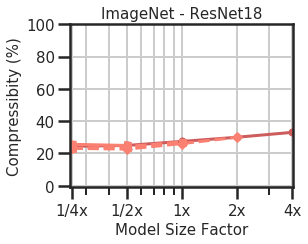

In [90]:
#Batch - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 20, 40, 60, 80, 100]
curves = 4
curve_labels = ['max.',  '4096', '2048', '1024']
curve_colors = ['indianred', 'salmon', 'salmon', 'salmon']
curve_styles = ['-', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'D']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

results = np.zeros((curves, sizes))
results_std = np.zeros((curves, sizes))

# both are indexed [nn_type][size_factor]

for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                            ['compressability_95'].iloc[0] for i in range(crosses)])
    results[curve_idx, size_idx] = np.mean(similiarity_ave)
    results_std[curve_idx, size_idx] = np.std(similiarity_ave)


batch_plot = [4096, 2048, 1024]
for ID in range(13):

    #print('Processing ID:', ID)
    opt = opts[ID]

    size_idx = size_idx_map[opt.dnn.factor]
    batch_idx = np.where(np.asarray(batch_plot) == opt.hyper.batch_size)[0]
    if len(batch_idx):
        csv_file = opt.csv_dir + opt.name + '_redundancy.csv'        
        df = pd.read_csv(csv_file)
        similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                                ['compressability_95'].iloc[0] for i in range(crosses)])
        results[int(batch_idx)+1, size_idx] = np.mean(similiarity_ave)
        results_std[int(batch_idx)+1, size_idx] = np.std(similiarity_ave)

results *= 100
results_std *= 100

leg_loc = (0.0, 0.42)

print_compress(r'ImageNet - ResNet18', results, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Batch} \bf{Size}$", 10,leg_loc, False,
                 "comp_imagenet_batch_test")


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

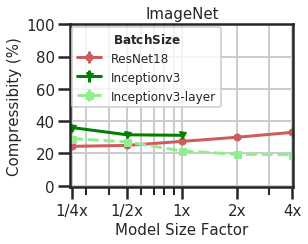

In [91]:
#Batch - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 20, 40, 60, 80, 100]
curves = 3
curve_labels = ['ResNet18',  'Inceptionv3', 'Inceptionv3-layer']
curve_colors = ['indianred', 'green', 'lightgreen']
curve_styles = ['-', '-', '--']
marker_styles = ['o', 'v', 's']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

results = np.zeros((curves, sizes))
results_std = np.zeros((curves, sizes))

# both are indexed [nn_type][size_factor]

for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                            ['compressability_95'].iloc[0] for i in range(crosses)])
    results[curve_idx, size_idx] = np.mean(similiarity_ave)
    results_std[curve_idx, size_idx] = np.std(similiarity_ave)

for ID in range(12,15):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 1  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                            ['compressability_95'].iloc[0] for i in range(crosses)])
    results[curve_idx, size_idx] = np.mean(similiarity_ave)
    results_std[curve_idx, size_idx] = np.std(similiarity_ave)
    
for ID in list(range(12,13)) + list(range(15,19)):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 2  # unregularized

    size_idx = size_idx_map[opt.dnn.factor_end]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == '7']
                            ['compressability_95'].iloc[0] for i in range(crosses)])
    results[curve_idx, size_idx] = np.mean(similiarity_ave)
    results_std[curve_idx, size_idx] = np.std(similiarity_ave)

results *= 100
results_std *= 100

leg_loc = (0.01, 0.49)

print_compress(r'ImageNet', results, results_std, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Batch} \bf{Size}$", 10,leg_loc, True,
                 "comp_imagenet_test")


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

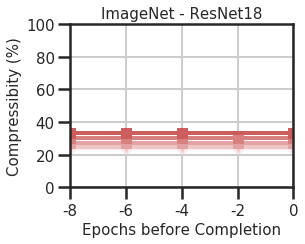

In [93]:
#Time - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')

curves = 5
curve_labels = ['x1/4',  'x1/2', 'x1', 'x2', 'x4']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'v', 's', 's', 's']
sizes = 5
size_factors = np.array([-4, -3, -2, -1, 0])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['-8', '-6', '-4', '-2', '0']
crosses=3
results = np.zeros((curves, sizes,2))

# both are indexed [nn_type][size_factor]

for ID in range(19, 38):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]

    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                            ['compressability_95'].iloc[0] for i in range(crosses)])
    results[size_idx][opt.time_step][0] = np.mean(similiarity_ave)
    results[size_idx][opt.time_step][1] = np.std(similiarity_ave)

    
for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                            ['compressability_95'].iloc[0] for i in range(crosses)])
    results[size_idx][-1][0] = np.mean(similiarity_ave)
    results[size_idx][-1][1] = np.std(similiarity_ave)
    
data = 100*results[:, :, 0]
stds = 100*results[:, :, 1]
title = r'ImageNet - ResNet18'
leg_title = r"$\bf{Model} \bf{Size}$"
leg_flag = True
rand_base = 0.1

leg_loc = (0.7, 0.040)

fig, ax = plt.subplots(figsize=(4, 3))
plt.title(title , fontsize=25)
plt.xlabel(r'Epochs before Completion', fontsize=25)
plt.ylabel('Compressibity (%)', fontsize=25)
plt.xlim((-4, 0))
plt.ylim((-0.01, 40))
plt.grid(True, which='both')
plt.xticks(size_factors, size_labels)
plt.yticks([0, 20, 40, 60, 80, 100])

for curve_idx in range(np.shape(data)[0]):
    non_0_idx = (data[curve_idx] != 0)
    plt.errorbar(size_factors[non_0_idx], data[curve_idx][non_0_idx], yerr=stds[curve_idx][non_0_idx], marker=marker_styles[curve_idx], color=curve_colors[curve_idx],
             linestyle=curve_styles[curve_idx], linewidth=4, markersize=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

if False:
    leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=12, title=leg_title)
    leg.get_title().set_fontsize('12')
plt.rc('xtick',labelsize=8)

plt.show()
fig.savefig("comp_imagenet_dynamics_test.pdf",format='pdf', bbox_inches='tight',dpi=1000)
    

In [26]:
stds

array([[2.43750000e+01, 2.43750000e+01, 2.43750000e+01, 2.43750000e+01,
        0.00000000e+00],
       [2.49218750e+01, 2.49218750e+01, 2.49218750e+01, 2.49218750e+01,
        2.77555756e-15],
       [2.74218750e+01, 2.74218750e+01, 2.74218750e+01, 2.74218750e+01,
        0.00000000e+00],
       [3.00000000e+01, 3.00000000e+01, 3.00000000e+01, 3.00000000e+01,
        0.00000000e+00],
       [3.30175781e+01, 3.30175781e+01, 3.30175781e+01, 0.00000000e+00,
        0.00000000e+00]])